In [ ]:
pip show huggingface_hub


In [ ]:
!pip install transformers
!pip install shap datasets
!pip install huggingface_hub[hf_xet]




In [1]:
import json
import shap
import torch
import requests
import itertools
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from transformers import pipeline
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [2]:
## 1. Loading and Exploring the GoEmotions Dataset
# We load the GoEmotions dataset (`train.tsv`) and map label IDs to their corresponding emotion names using the `emotions.txt` file.

response = requests.get("https://raw.githubusercontent.com/Hadia-Eshan/politics_of_emotion/main/data/emotions.txt")
emotions = [line.strip() for line in response.text.split('\n') if line.strip()]
id2emotion = {i: emotion for i, emotion in enumerate(emotions)}
train_df = pd.read_csv('https://raw.githubusercontent.com/Hadia-Eshan/politics_of_emotion/main/data/train.tsv', sep='\t', header=None, names=['text', 'label', 'id'])

# Drop bad rows (only keep if label is digits or comma-separated digits)
train_df = train_df[train_df['label'].astype(str).str.match(r'^\d+(,\d+)*$', na=False)].copy()

# Map label(s) to emotion names
def map_labels(label_str):
    ids = list(map(int, label_str.split(',')))
    return [id2emotion[i] for i in ids]
train_df['emotion_names'] = train_df['label'].apply(map_labels)
train_df.head()

,text,label,id,emotion_names
0,My favourite food is anything I didn't have to...,27,eebbqej,[neutral]
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[anger]
3,To make her feel threatened,14,ed7ypvh,[fear]
4,Dirty Southern Wankers,3,ed0bdzj,[annoyance]


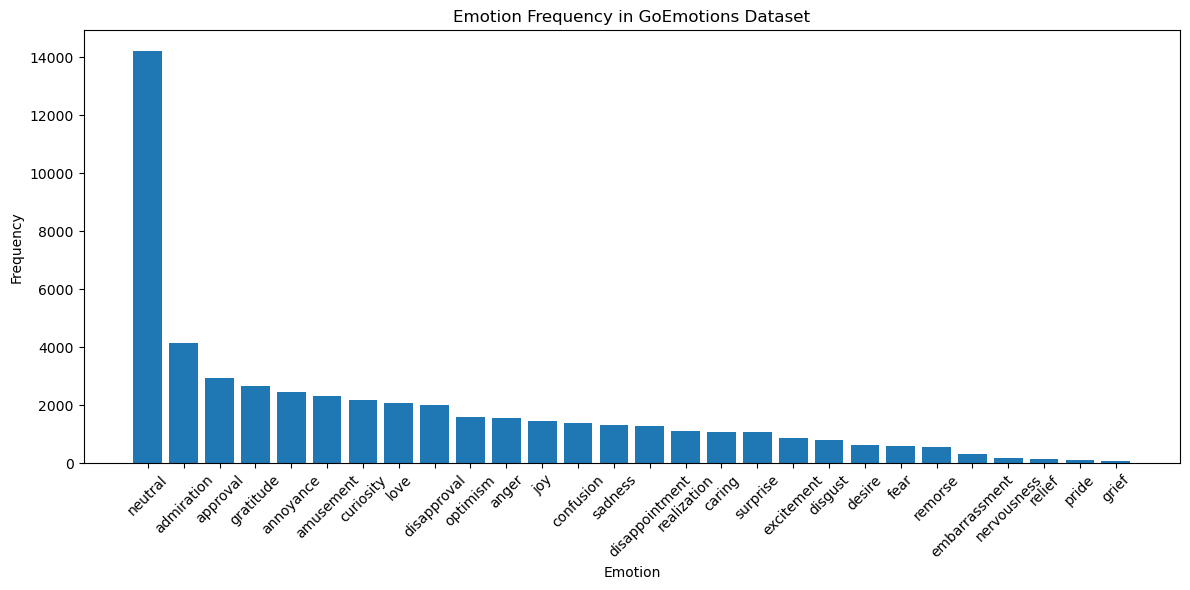

In [5]:
## 2. Emotion Frequency Distribution
#This section visualizes how often each emotion label appears in the GoEmotions dataset, providing insight into label imbalance or dominance.


# emotion names into one list
all_emotions = [emotion for sublist in train_df['emotion_names'] for emotion in sublist]
emotion_counts = Counter(all_emotions)
emotion_freq_df = pd.DataFrame(emotion_counts.items(), columns=['emotion', 'count'])
emotion_freq_df = emotion_freq_df.sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(emotion_freq_df['emotion'], emotion_freq_df['count'])
plt.xticks(rotation=45)
plt.xlabel("Emotion")
plt.ylabel("Frequency")
plt.title("Emotion Frequency in GoEmotions Dataset")
plt.tight_layout()
plt.show()


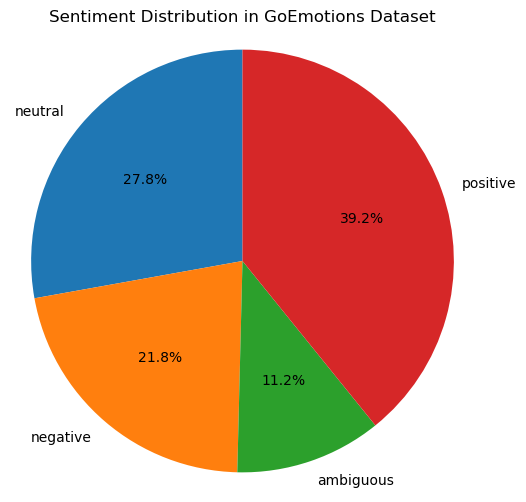

In [11]:
## 3. Sentiment Category Breakdown
# Using the provided `sentiment_dict.json`, we group emotions into broader categories (positive, negative, ambiguous) and visualize their distribution with a pie chart.

sentiment_dict = json.loads(requests.get("https://raw.githubusercontent.com/Hadia-Eshan/politics_of_emotion/main/data/sentiment_dict.json").text)

# Build emotion → sentiment mapping
emotion_to_sentiment = {}
for sentiment, emotion_list in sentiment_dict.items():
    for emo in emotion_list:
        emotion_to_sentiment[emo] = sentiment
sentiment_counts = defaultdict(int)

for emotion_list in train_df['emotion_names']:
    for emo in emotion_list:
        sentiment = emotion_to_sentiment.get(emo, 'unknown')
        sentiment_counts[sentiment] += 1

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), autopct='%1.1f%%', startangle=90)
plt.title("Sentiment Distribution in GoEmotions Dataset")
plt.axis('equal')
plt.show()


In [ ]:
## 4. Emotion Co-occurrence Heatmap
# We analyze how emotions tend to co-occur within the same text by generating a symmetric co-occurrence matrix and plotting it as a heatmap.


co_matrix = defaultdict(lambda: defaultdict(int))

# 2. Count co-occurring emotion pairs
for emo_list in train_df['emotion_names']:
    if len(emo_list) > 1:
        for e1, e2 in itertools.combinations(sorted(emo_list), 2):
            co_matrix[e1][e2] += 1
            co_matrix[e2][e1] += 1  # symmetric
co_df = pd.DataFrame(co_matrix).fillna(0)

# reorder for better visual
co_df = co_df.loc[sorted(co_df.index), sorted(co_df.columns)]

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_df, cmap='Blues', linewidths=0.5)
plt.title("Emotion Co-occurrence Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
## 5. Single vs. Multi-Emotion Comment Examples
# We display examples of comments with a single emotion label and those with multiple labels to understand the variability in emotional richness.


train_df['emotion_count'] = train_df['emotion_names'].apply(len)

# Comments with exactly 1 emotion
one_emotion = train_df[train_df['emotion_count'] == 1].sample(5, random_state=1)

# Comments with 3 or more emotions
multi_emotion = train_df[train_df['emotion_count'] >= 3].sample(5, random_state=2)

# 4. low-emotion
print("Low-emotion comments (1 label):\n")
for i, row in one_emotion.iterrows():
    print(f"- {row['emotion_names'][0].upper()}: {row['text']}\n")

# 5. high-emotion
print("\nHigh-emotion comments (3+ labels):\n")
for i, row in multi_emotion.iterrows():
    print(f"- {', '.join(row['emotion_names']).upper()}: {row['text']}\n")


In [ ]:
'''
6. Load Pre-trained Emotion Classification Model
We load a transformer model fine-tuned on GoEmotions to perform multi-label emotion classification 
on political texts.
'''

# Using DistilBERT model fine-tuned on GoEmotions
model_name = "joeddav/distilbert-base-uncased-go-emotions-student"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Creates a multi-label classifier that returns all relevant emotion scores
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, top_k=None, truncation=True)

In [ ]:
## 7. Demo: Emotion Prediction on Sample Political Texts

def classify_emotions(data, classifier, threshold=0.1):
    """
    Takes a list of dicts with 'text', 'topic', and 'group', 
    returns a DataFrame with predicted emotions and metadata.
    """
    results = []
    for item in data:
        preds = classifier(item['text'])[0]
        top_preds = [p for p in preds if p['score'] > threshold]
        results.append({
            'text': item['text'],
            'topic': item['topic'],
            'group': item['group'],
            'emotions': [p['label'] for p in top_preds],
            'scores': [round(p['score'], 2) for p in top_preds]
        })
    return pd.DataFrame(results)



In [ ]:
political_texts = [
    {"text": "We will defend democracy and protect the rights of every citizen.", "topic": "Democracy", "group": "Group A"},
    {"text": "Their reckless spending has put our country in danger.", "topic": "Economy", "group": "Group B"},
    {"text": "We are proud of the progress we've made in healthcare.", "topic": "Healthcare", "group": "Group A"},
    {"text": "They continue to spread fear and misinformation.", "topic": "Disinformation", "group": "Group B"},
    {"text": "Justice will prevail, and the people will be heard.", "topic": "Justice", "group": "Group A"},
    
    {"text": "This administration has failed our economy time and again.", "topic": "Economy", "group": "Group B"},
    {"text": "We stand united against corruption and inequality.", "topic": "Justice", "group": "Group A"},
    {"text": "Their policies are built on lies and division.", "topic": "Disinformation", "group": "Group B"},
    {"text": "Healthcare is a right, not a privilege.", "topic": "Healthcare", "group": "Group A"},
    {"text": "They ignore science and continue to mislead the public.", "topic": "Disinformation", "group": "Group B"},
]



emotion_df = classify_emotions(political_texts, classifier)
emotion_df


In [ ]:

## 8. Emotion Frequency in Political Texts
all_preds = [emotion for emolist in emotion_df['emotions'] for emotion in emolist]

# Count emotion occurrences
emotion_counts = Counter(all_preds)
emotion_df_plot = pd.DataFrame(emotion_counts.items(), columns=['emotion', 'count'])
emotion_df_plot = emotion_df_plot.sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(emotion_df_plot['emotion'], emotion_df_plot['count'], color='skyblue')
plt.title("Emotion Frequency in Political Texts")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
## 9. Emotion Heatmap by Topic

# Expand the emotion list into one row per emotion
exploded = emotion_df.explode('emotions')

# Group by topic and emotion
grouped = exploded.groupby(['topic', 'emotions']).size().unstack(fill_value=0)

# Plot as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(grouped, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Emotion Use by Topic")
plt.ylabel("Topic")
plt.xlabel("Emotion")
plt.tight_layout()
plt.show()


In [ ]:
## 10. Emotion Comparison Between Groups

def count_emotions_from_df(df, group_name, threshold=0.1):
    emotion_counter = Counter()
    group_rows = df[df['group'] == group_name]
    for _, row in group_rows.iterrows():
        for emotion, score in zip(row['emotions'], row['scores']):
            if score > threshold:
                emotion_counter[emotion] += 1
    return emotion_counter


# Count for each group
counter_a = count_emotions_from_df(emotion_df, "Group A")
counter_b = count_emotions_from_df(emotion_df, "Group B")

# Merge and plot
all_emotions = sorted(set(counter_a) | set(counter_b))
counts_a = [counter_a.get(e, 0) for e in all_emotions]
counts_b = [counter_b.get(e, 0) for e in all_emotions]

# Plot
x = range(len(all_emotions))
plt.figure(figsize=(12, 6))
plt.bar(x, counts_a, width=0.4, label="Group A", align='center')
plt.bar([i + 0.4 for i in x], counts_b, width=0.4, label="Group B", align='center')
plt.xticks([i + 0.2 for i in x], all_emotions, rotation=45)
plt.ylabel("Emotion Count")
plt.title("Emotion Usage Comparison by Group")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
def visualize_attention_with_emotions(sentence, model, tokenizer, classifier, threshold=0.1):
    """
    Displays attention heatmap + predicted emotions for a given sentence.
    
    Parameters:
    - sentence (str): Political sentence to analyze
    - model: transformer model
    - tokenizer: associated tokenizer
    - classifier: text-classification pipeline
    - threshold (float): minimum score to include an emotion
    """
    print(f"\n🗣️ Sentence: {sentence}\n")
    
    # Tokenize
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True)
    
    # Predict emotions
    preds = classifier(sentence)[0]
    top_emotions = [p['label'].upper() for p in preds if p['score'] > threshold]
    
    # Attention output
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions[-1]
    attention_matrix = attentions[0, 0]
    
    # Tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap="Reds")
    emotion_str = ", ".join(top_emotions) if top_emotions else "No strong emotion"
    plt.title(f"Attention Heatmap – Final Layer, Head 1\nPredicted Emotions: {emotion_str}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


visualize_attention_with_emotions(political_texts[3]['text'], model, tokenizer, classifier)



In [ ]:
def explain_with_shap(sentence, classifier):
    """
    Generate SHAP explanation for a given sentence using a text classification pipeline.
    
    Parameters:
        sentence (str): The input sentence to analyze.
        classifier: HuggingFace pipeline object for text classification.
    """
    # Predict emotions
    preds = classifier(sentence)[0]
    top_preds = [(p['label'], round(p['score'], 3)) for p in preds if p['score'] > 0.1]

    # Initialize SHAP explainer
    explainer = shap.Explainer(classifier, masker=shap.maskers.Text(tokenizer=classifier.tokenizer))
    shap_values = explainer([sentence])

    # Print sentence and predicted emotions
    print(f"\n📌 Text: {sentence}")
    print("🎯 Predicted Emotions:")
    for label, score in top_preds:
        print(f"   → {label.upper()} ({score})")

    # Plot SHAP explanation
    shap.plots.text(shap_values[0])
    
explain_with_shap(political_texts[3]['text'], classifier)
